# Informe de Predicción de la Tasa Representativa del Mercado (TRM) en Colombia

Elaborado por: Juan David Ortega, Sergio Herrera Quijano y Oscar Ivan Bautista
___

Este informe describe el proceso de construcción, entrenamiento y evaluación de un modelo LSTM para predecir la Tasa Representativa del Mercado (TRM) en Colombia. A través de un modelo de redes neuronales LSTM, buscamos identificar patrones y tendencias en los datos históricos de la TRM para prever valores futuros con mayor precisión.

## Importe de librerias

##### Las librerías son componentes clave en el análisis y predicción de series temporales. `pandas` y `numpy` permiten manipular y transformar los datos; `matplotlib` y `seaborn` se usan para visualización; `MinMaxScaler` ayuda a escalar los datos y `tensorflow.keras` permite construir el modelo LSTM.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

## Carga y Preprocesamiento de Datos de la TRM

#### Los datos de la Tasa Representativa del Mercado (TRM) fueron obtenidos de la [página del Banco de la República de Colombia](https://www.banrep.gov.co/es/estadisticas/trm), cubriendo el periodo entre el 31 de octubre de 2021 y el 31 de octubre de 2024. Cargamos esta base de datos y realizamos una limpieza inicial para asegurar la compatibilidad y precisión de los datos. Convertimos la columna de fecha en un índice de tipo `datetime`, facilitando la manipulación temporal, y transformamos los valores de `TRM` a formato `float`, asegurando la compatibilidad numérica. Esta estructuración permite un análisis temporal y numérico preciso para nuestro modelo y visualizaciones.


In [29]:
data = pd.read_csv('BASES\\1.1.2.TCM_Para rango de fechas dado.csv')

In [30]:
data.head()

,Año,Fecha (dd/mm/aaaa),TRM,Día del mes,Mes,Id Mes
0,2024,2024-10-31,"4413,46",31,Octubre,10
1,2024,2024-10-30,"4367,39",30,Octubre,10
2,2024,2024-10-29,"4342,9",29,Octubre,10
3,2024,2024-10-28,"4316,73",28,Octubre,10
4,2024,2024-10-27,"4316,73",27,Octubre,10


In [31]:
data['Fecha (dd/mm/aaaa)'] = pd.to_datetime(data['Fecha (dd/mm/aaaa)'], format='%Y-%m-%d')

In [32]:
data['TRM'] = data['TRM'].str.replace(',', '.').astype(float)

In [33]:
data.head()

,Año,Fecha (dd/mm/aaaa),TRM,Día del mes,Mes,Id Mes
0,2024,2024-10-31,4413.46,31,Octubre,10
1,2024,2024-10-30,4367.39,30,Octubre,10
2,2024,2024-10-29,4342.90,29,Octubre,10
3,2024,2024-10-28,4316.73,28,Octubre,10
4,2024,2024-10-27,4316.73,27,Octubre,10


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Año                 1097 non-null   int64         
 1   Fecha (dd/mm/aaaa)  1097 non-null   datetime64[ns]
 2   TRM                 1097 non-null   float64       
 3   Día del mes         1097 non-null   int64         
 4   Mes                 1097 non-null   object        
 5   Id Mes              1097 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 51.6+ KB


In [35]:
data = data.drop(columns=['Año', 'Día del mes', 'Mes', 'Id Mes'])

In [36]:
data.set_index('Fecha (dd/mm/aaaa)', inplace=True)

In [37]:
data

,TRM
Fecha (dd/mm/aaaa),
2024-10-31,4413.46
2024-10-30,4367.39
2024-10-29,4342.90
2024-10-28,4316.73
2024-10-27,4316.73
...,...
2021-11-04,3837.84
2021-11-03,3778.69
2021-11-02,3784.44


## Visualización de la TRM

#### Observamos la evolución temporal de la TRM en Colombia, identificando posibles patrones o tendencias. La visualización es crucial para determinar variaciones estacionales o tendencias generales en la serie, que el modelo intentará capturar


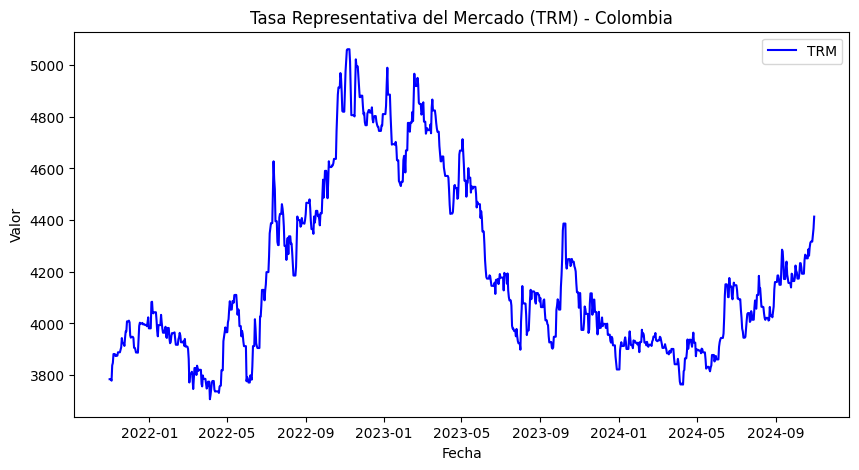

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['TRM'], color='blue', label='TRM')
plt.title('Tasa Representativa del Mercado (TRM) - Colombia')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

## Escalado de los Datos

#### Escalar los datos entre 0 y 1 mejora la eficiencia y precisión de los cálculos en la red LSTM. Esto se debe a que las redes neuronales suelen converger más rápido y de manera más estable cuando los datos tienen un rango uniforme.

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['TRM_scaled'] = scaler.fit_transform(data[['TRM']])

## Creación de Secuencias para el Modelo LSTM
#### La función `create_sequences` crea conjuntos de entrenamiento y prueba. Cada secuencia de 60 valores consecutivos permite al modelo capturar patrones temporales en los datos de la TRM. Los conjuntos de datos se dividen en 80% para entrenamiento y 20% para prueba, asegurando una correcta validación del modelo.

In [40]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [41]:
train_size = int(len(data) * 0.8)
train_data, test_data = data['TRM_scaled'].values[:train_size], data['TRM_scaled'].values[train_size:]

In [42]:
seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

## Configuración y Compilación del Modelo LSTM
#### La estructura del modelo LSTM cuenta con dos capas LSTM que capturan relaciones temporales y dos capas `Dense` para la salida. Usamos el optimizador Adam y `mean_squared_error` para reducir el error en las predicciones, dado que se trata de un problema de regresión.

In [43]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [44]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

C:\Users\juano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento y Early Stopping
#### El `EarlyStopping` evita el sobreajuste del modelo al detener el entrenamiento si no mejora en 10 épocas. Este proceso garantiza que el modelo conserve los mejores pesos observados durante el entrenamiento y evita un exceso de iteraciones innecesarias.

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [48]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0902 - val_loss: 0.0084
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0073 - val_loss: 0.0011
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0040 - val_loss: 9.6731e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036 - val_loss: 8.8653e-04
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035 - val_loss: 9.7310e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0030 - val_loss: 8.4294e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0031 - val_loss: 9.0674e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0030 - val_loss: 8.9796e-04
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0026 - val_loss: 8.0400e-04
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━

## Predicción y Desescalado de Resultados

#### Convertimos las predicciones y valores reales de vuelta a la escala original. Esto nos permite comparar los resultados en los mismos términos de la TRM y analizar la precisión del modelo.

In [49]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


In [50]:
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


## Evaluación del Modelo
#### Las métricas obtenidas (MAE, MSE, RMSE y R²) ofrecen una evaluación cuantitativa de la precisión del modelo. Un MAE bajo y un R² alto indican un buen ajuste y precisión en las predicciones.

In [51]:
mae = np.mean(np.abs(predictions - y_test_rescaled))
mse = np.mean((predictions - y_test_rescaled) ** 2)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 18.91
Mean Squared Error (MSE): 701.54
Root Mean Squared Error (RMSE): 26.49


In [52]:
r2 = r2_score(y_test_rescaled, predictions)
r2_percentage = r2 * 100

print(f'Coefficient of Determination (R²): {r2:.4f}')
print(f'Coefficient of Determination (R²) as Percentage: {r2_percentage:.2f}%')

Coefficient of Determination (R²): 0.9038
Coefficient of Determination (R²) as Percentage: 90.38%


## Visualización de las Predicciones
#### La comparación gráfica entre los valores reales y las predicciones muestra visualmente la precisión del modelo. Si las líneas de predicción y valores reales se alinean estrechamente, el modelo captura bien las tendencias de la TRM.

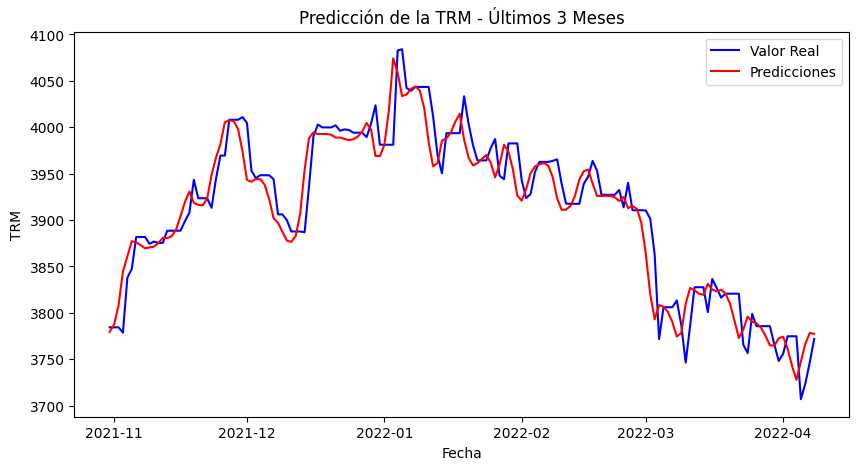

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[-len(y_test):], y_test_rescaled, color='blue', label='Valor Real')
plt.plot(data.index[-len(predictions):], predictions, color='red', label='Predicciones')
plt.title('Predicción de la TRM - Últimos 3 Meses')
plt.xlabel('Fecha')
plt.ylabel('TRM')
plt.legend()
plt.show()

## Guardado del Modelo
#### Guardamos el modelo en formato HDF5 para poder reutilizarlo o implementarlo en futuros análisis o despliegues sin necesidad de reentrenarlo.

In [54]:
model.save('modelo_trm.h5')
print("Modelo guardado como 'modelo_trm.h5'")

Modelo guardado como 'modelo_trm.h5'


## Análisis de Resultados
#### Las métricas obtenidas, como el MAE, MSE y el RMSE, ofrecen una evaluación de precisión del modelo, mientras que el R² indica la proporción de variabilidad explicada. Un valor de R² cercano a 1 (o al 100%) sugiere que el modelo tiene un ajuste adecuado.

## Viabilidad de Despliegue

#### Si las métricas de error son bajas y el R² es alto (por ejemplo, > 0.9), el modelo puede considerarse para su despliegue. En caso contrario, podría ser necesario ajustar hiperparámetros, probar arquitecturas adicionales o realizar más procesamiento de datos antes de considerar el despliegue.

## Conclusión Final
#### El modelo de predicción de TRM basado en LSTM ofrece un enfoque eficaz para predecir la TRM, siempre y cuando cumpla con los estándares de precisión. De ser así, podría ser implementado en una aplicación financiera que ayude a estimar tendencias de cambio.